## Building a Pipeline: Clean Data Features and Prepare for Modeling

Using the Titanic dataset from [this](https://www.kaggle.com/c/titanic/overview) Kaggle competition.

This dataset contains information about 891 people who were on board the ship when departed on April 15th, 1912. As noted in the description on Kaggle's website, some people aboard the ship were more likely to survive the wreck than others. There were not enough lifeboats for everybody so women, children, and the upper-class were prioritized. Using the information about these 891 passengers, the challenge is to build a model to predict which people would survive based on the following fields:

- **Name** (str) - Name of the passenger
- **Pclass** (int) - Ticket class
- **Sex** (str) - Sex of the passenger
- **Age** (float) - Age in years
- **SibSp** (int) - Number of siblings and spouses aboard
- **Parch** (int) - Number of parents and children aboard
- **Ticket** (str) - Ticket number
- **Fare** (float) - Passenger fare
- **Cabin** (str) - Cabin number
- **Embarked** (str) - Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)



### Read in Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

titanic = pd.read_csv('../titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We will first take a look through the actual data. We can see personal information such as the Name column, but because this is public knowledge, it is acceptable to leave in the data set. With the major portion of our effort going towards identifying factors of survival, we can group `Name`, `PassengerID`, and `Ticket` arent going to be of much use and can be removed. 

In addition to removing the previous three columns, we see that `Sex`, `Cabin`, and `Embarked` are non-numerical features. We plan to explore the numeric features a little bit later, so for now, we will group all the non-numeric features and personal identifying factors and remove from the larger data set. The temporary removal of these columns will allow us to concentrate our efforts towards exploring the continous features. 

In [2]:
#drop categorical features
cat_feat = ['PassengerId', 'Name', 'Ticket', 'Sex', 'Cabin', 'Embarked']
titanic.drop(cat_feat, axis=1, inplace=True)
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


### Explore continuous features

In [3]:
#describe method is helpful to get the shape of of the data
#because it provides count, mean, and statistical distribution
#details of your data set
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


When looking at the count values, we see the `Age` column has 714 values, whereas the majority of the other columns contain 891 values. This could be explained by missing values within that column, which we now want to explore further. 

Another quick callout for this data set is that for the `Survived` column, which is our target variable, is binary, which means the value should be either 0 or 1. The mean value in this instance tells us what percentage of passengers survived, **38.4%**.

The next thing that is useful to know, is to understand which features might be strong indicators for whether a passenger survived or not. We can use a GroupBy method on the Survived column, and generate an average value for the two Survived outputs (0 or 1) of the remaining data frame.

In [4]:
#groupby will create two separate groups (survived/did not survive)
#.mean will return average value for each feature of both groups
titanic.groupby('Survived').mean()

,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,
0,2.531876,30.626179,0.553734,0.329690,22.117887
1,1.950292,28.343690,0.473684,0.464912,48.395408


From this table, we see the average `Age` of a person who did not survive is **30.6** and the average `Age` of someone who survived is **28.3**. Additional features that stand out include `PClass` and `Fare`. Both indicate passengers who had better class or spent more for a ticket were more likely to survive. This is good for high level details and we will continue to peel the onion in regards to what the rest of this data can provide. 

We saw previously, the `Age` column had several missing values. We now want to know if these values are missing at random (never reported for certain people) or missing in a systematic way (not asking age of a particular class) because this will determine how we handle the missing values. To explore this, we will use the Groupby method again, but call on the `Age` feature, with the isnull method to return a true/false statement of missing data. Let's see what we can find below:

In [5]:
#Age=True means missing value, Age=False means no missing value
titanic.groupby(titanic['Age'].isnull()).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Age,,,,,,
False,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
True,0.293785,2.598870,NaN,0.564972,0.180791,22.158567


We see from the table above, there does appear to be some splitting. Individuals without `Age` reported had a lower percentage of Surviving, a higher `PClass`, fewer parents or children (`SibSP` & `Parch`), and had a lower `Fare` price. 

These are good findings, but nothing jumps out to handle these missing values in a specific way. We will proceed with filling the missing values for `Age` with the average age of **29.69**. 

We also found that `Fare` and `Pclass` may be strong indicators for whether a passenger `Survived` or not. 

### Explore categorical features

In [6]:
#load original data set
titanic = pd.read_csv('../titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
#Drop continuous features
cont_feat = ['PassengerId', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Fare']
titanic.drop(cont_feat, axis=1, inplace=True)
titanic.head()

,Survived,Sex,Ticket,Cabin,Embarked
0,0,male,A/5 21171,NaN,S
1,1,female,PC 17599,C85,C
2,1,female,STON/O2. 3101282,NaN,S
3,1,female,113803,C123,S
4,0,male,373450,NaN,S


With the information provided in the table above, let's try exploring the columns for `Sex`, `Cabin`, and `Embarked`.

In [8]:
#info() will share how many non-null entries are in the data set
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Survived  891 non-null    int64 
 1   Sex       891 non-null    object
 2   Ticket    891 non-null    object
 3   Cabin     204 non-null    object
 4   Embarked  889 non-null    object
dtypes: int64(1), object(4)
memory usage: 34.9+ KB


We see `Cabin` has 204 non-null features, meaning there are a lot of missing values in this column. And `Embarked` has just a few missing values. 

In [9]:
#creates two groups; only returning the Survived because it is the only remaining
#continuous feature in the data set.
#Cabin=True means missing data; Cabin=False means no missing data
titanic.groupby(titanic['Cabin'].isnull()).mean()

,Survived
Cabin,
False,0.666667
True,0.299854


The table above shows a dramatic split where **66.7%** of people who have non-missing `Cabin` values Survived, and **33.3%** of people who had a missing `Cabin` value survived. When we looked at Age, we saw it appeared to be very random, but in this case with `Cabin`, the missing data does not appear to be missing at random (actually strong indicator of Survival). 

In [10]:
titanic['Cabin_ind'] = np.where(titanic['Cabin'].isnull(), 0, 1)
titanic.head(10)

,Survived,Sex,Ticket,Cabin,Embarked,Cabin_ind
0,0,male,A/5 21171,NaN,S,0
1,1,female,PC 17599,C85,C,1
2,1,female,STON/O2. 3101282,NaN,S,0
3,1,female,113803,C123,S,1
4,0,male,373450,NaN,S,0
5,0,male,330877,NaN,Q,0
6,0,male,17463,E46,S,1
7,0,male,349909,NaN,S,0
8,1,female,347742,NaN,S,0
9,1,female,237736,NaN,C,0


### Clean continuous variables
1. Fill in missing values for `Age`
2. Combine `SibSp` & `Parch`
3. Drop irrelevant/repetitive variables (`SibSp`, `Parch`, `PassengerId`)

#### Fill missing for `Age`
We will use the average age value to fill the missing values in the Age column.

In [55]:
#load original data set
titanic = pd.read_csv('../titanic.csv')
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [56]:
#fill na values with mean of Age; replacing with the average prevents any 
#bias towards the outcome of the model one way or the other
titanic['Age'].fillna(titanic['Age'].mean(), inplace=True)

#### Combine `SibSp` & `Parch`

<Figure size 432x288 with 0 Axes>

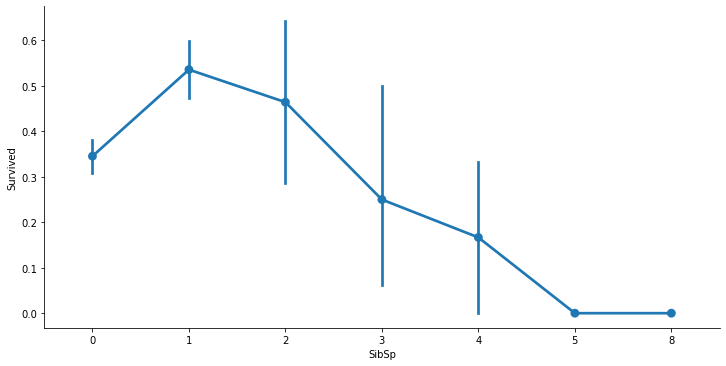

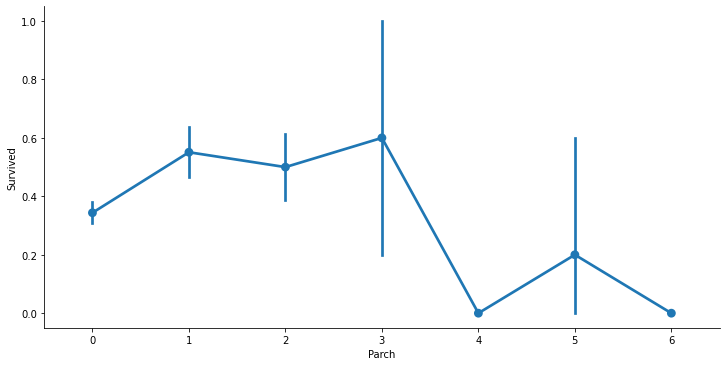

In [57]:
#create loop to iterate through categorical features SibSP and Parch
#this will create plots for both features based on Survival 
for i, col in enumerate(['SibSp', 'Parch']):
    plt.figure(i)
    sns.catplot(x=col, y='Survived', data=titanic, kind='point', aspect=2, )

In [58]:
#merging similar features into a single column
titanic['Family_cnt'] = titanic['SibSp'] + titanic['Parch']

#### Drop unnnecessary variables

In [59]:
#necessary to drop the merged columns to prevent multicollinearity;
#multiple features accounting for the same information (family size)
#model has difficult time providing values to those features due to high
#correlation; creates negative consequences on performance  
titanic.drop(['PassengerId', 'SibSp', 'Parch'], axis=1, inplace=True)

In [67]:
titanic.head(10)

,Survived,Pclass,Sex,Age,Fare,Family_cnt,Cabin_ind
0,0,3,0,22.000000,7.2500,1,0
1,1,1,1,38.000000,71.2833,1,1
2,1,3,1,26.000000,7.9250,0,0
3,1,1,1,35.000000,53.1000,1,1
4,0,3,0,35.000000,8.0500,0,0
5,0,3,0,29.699118,8.4583,0,0
6,0,1,0,54.000000,51.8625,0,1
7,0,3,0,2.000000,21.0750,4,0
8,1,3,1,27.000000,11.1333,2,0
9,1,2,1,14.000000,30.0708,1,0


### Clean categorical variables
1. Create an indicator variable in place of `Cabin`
2. Convert `Sex` to a numeric variable
3. Drop irrelevant/repetitive variables (`Cabin`, `Embarked`, `Name`, `Ticket`)

#### Create indicator for `Cabin`

In [61]:
titanic['Cabin_ind'] = np.where(titanic['Cabin'].isnull(), 0, 1)

#### Convert `Sex` to numeric

In [62]:
gender_num = {'male': 0, 'female': 1}

titanic['Sex'] = titanic['Sex'].map(gender_num)

#### Drop unnecessary variables

In [63]:
titanic.drop(['Cabin', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)
titanic.head(5)

,Survived,Pclass,Sex,Age,Fare,Family_cnt,Cabin_ind
0,0,3,0,22.0,7.2500,1,0
1,1,1,1,38.0,71.2833,1,1
2,1,3,1,26.0,7.9250,0,0
3,1,1,1,35.0,53.1000,1,1
4,0,3,0,35.0,8.0500,0,0


### Split into train, validation, and test set

In [64]:
features = titanic.drop('Survived', axis=1)
labels = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size= 0.4, random_state = 42) 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42) 

In [65]:
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(labels),2))

0.6
0.2
0.2


In [66]:
X_train.to_csv('../train_features.csv', index=False)
X_val.to_csv('../val_features.csv', index=False)
X_test.to_csv('../test_features.csv', index=False)

y_train.to_csv('../train_labels.csv', index=False)
y_val.to_csv('../val_labels.csv', index=False)
y_test.to_csv('../test_labels.csv', index=False)